# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

### 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


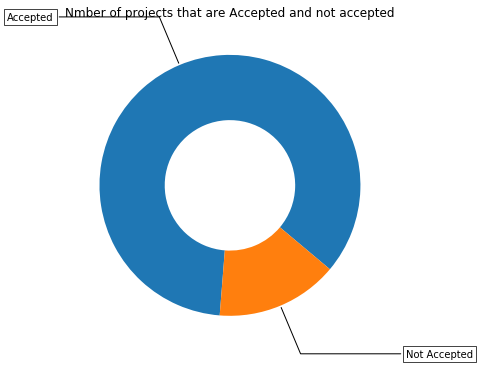

In [5]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### 1.2.1 Univariate Analysis: School State

In [6]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

'''# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')##'''

'# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620\n\nscl = [[0.0, \'rgb(242,240,247)\'],[0.2, \'rgb(218,218,235)\'],[0.4, \'rgb(188,189,220)\'],            [0.6, \'rgb(158,154,200)\'],[0.8, \'rgb(117,107,177)\'],[1.0, \'rgb(84,39,143)\']]\n\ndata = [ dict(\n        type=\'choropleth\',\n        colorscale = scl,\n        autocolorscale = False,\n        locations = temp[\'state_code\'],\n        z = temp[\'num_proposals\'].astype(float),\n        locationmode = \'USA-states\',\n        text = temp[\'state_code\'],\n        marker = dict(line = dict (color = \'rgb(255,255,255)\',width = 2)),\n        colorbar = dict(title = "% of pro")\n    ) ]\n\nlayout = dict(\n        title = \'Project Proposals % of Acceptance Rate by US States\',\n        geo = dict(\n            scope=\'usa\',\n            projection=dict( type=\'albers usa\' ),\n            showlakes = True,\n            lakecolor = \'rgb(255, 255, 255)\',\n        ),\n    )\n\nfig = go.Figure(data=dat

In [7]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


#### Observation

States like Vermont and District of Columbia have lowest Number of Project Approvals.
On the other hand states like Delaware and North Dakota have highest Number of Project Approvals.

In [8]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [9]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

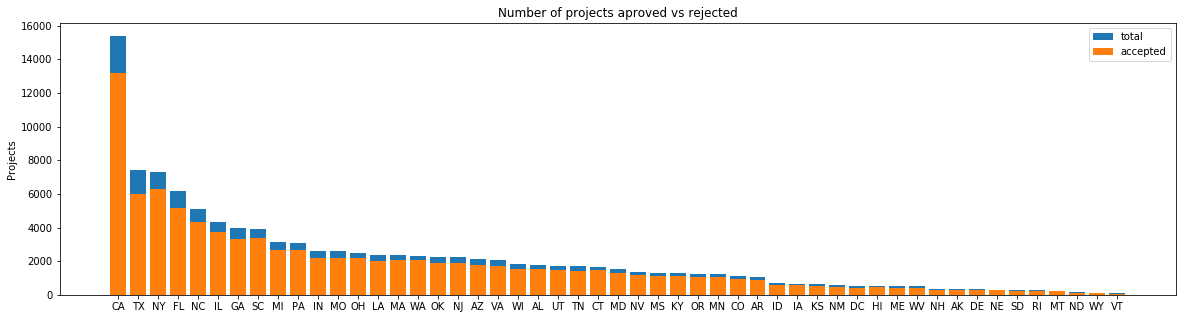

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [10]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

### 1.2.2 Univariate Analysis: teacher_prefix

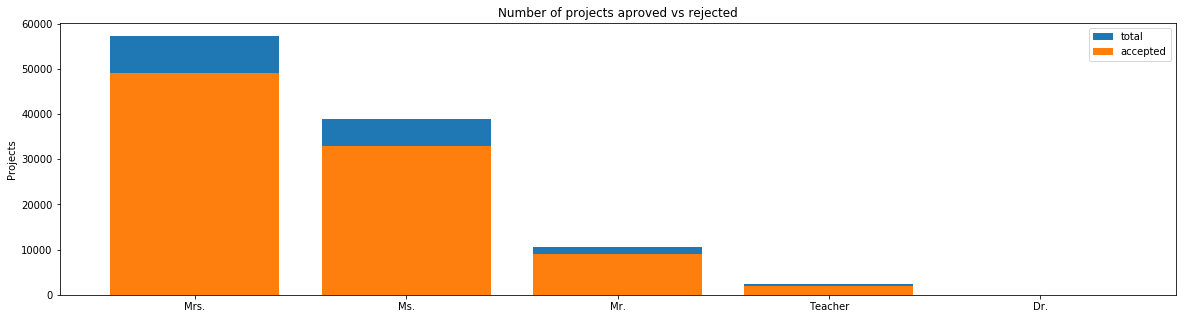

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [11]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

#### Observation

It looks like teachers who have slighty higher experience have more no of Project Approvals. Also female teachers have submitted more projects than male teachers.

### 1.2.3 Univariate Analysis: project_grade_category

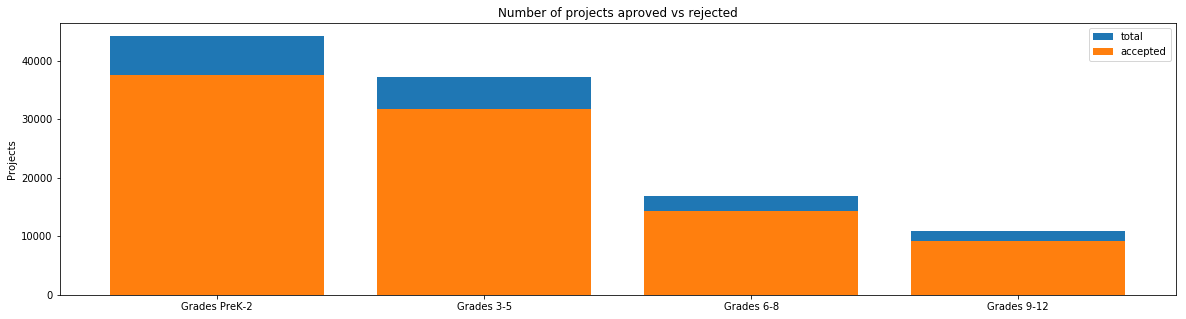

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [12]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

#### Observations

Project which belong to Grades (3-5) have a highest approval rate of 85%

### 1.2.4 Univariate Analysis: project_subject_categories

In [13]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [14]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

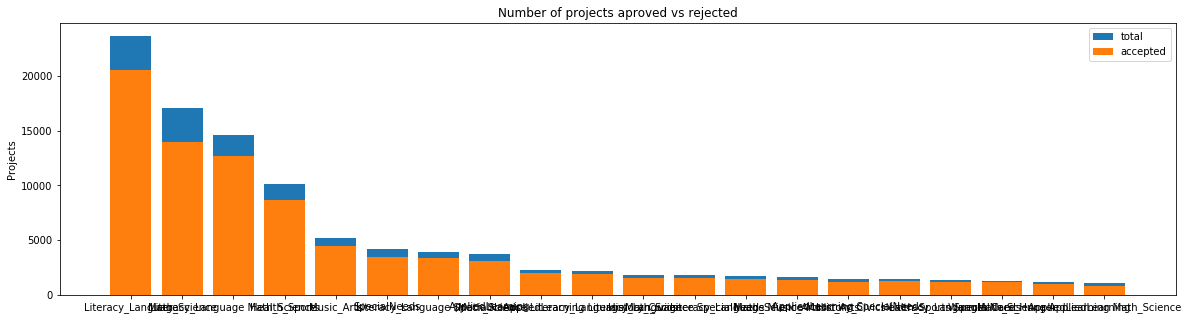

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [15]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

#### Obseravtions

Project which belong to categories Literacy-Language and Math-Science have a approval rate of 86% and Project which belong to categories Warmth,Care,Hunger have a approval rate of 93%.
Maybe the Donors are more sympathetic towards hunger and poverty.

In [16]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

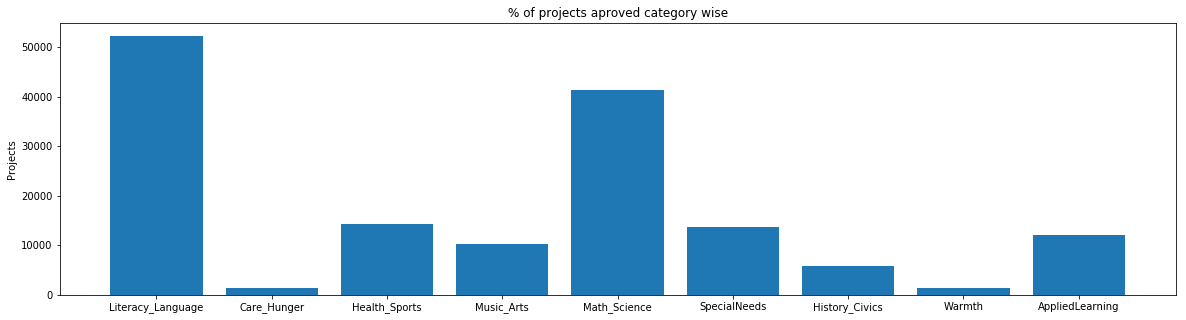

In [17]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [18]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Literacy_Language    :     52239
Care_Hunger          :      1388
Health_Sports        :     14223
Music_Arts           :     10293
Math_Science         :     41421
SpecialNeeds         :     13642
History_Civics       :      5914
Warmth               :      1388
AppliedLearning      :     12135


#### Observations

If we look at individual categories looks like if a Project belongs to either Literacy Language or Math Science have a high chance of approval.
Maybe the donors care more about technological advancements.

### 1.2.5 Univariate Analysis: project_subject_subcategories¶

In [19]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [20]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

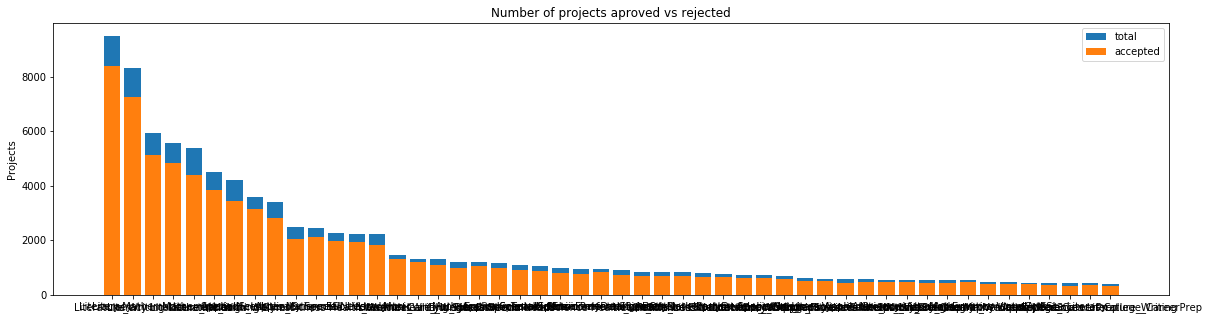

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [21]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [22]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

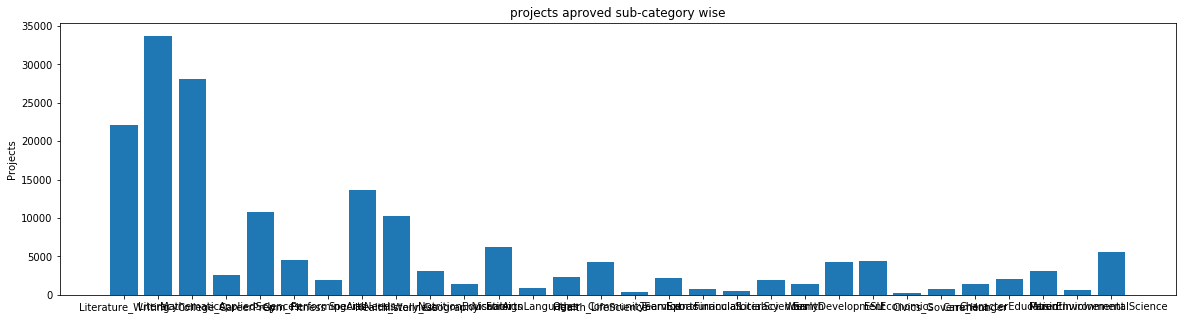

In [23]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('projects aproved sub-category wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [24]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Literature_Writing   :     22179
Literacy             :     33700
Mathematics          :     28074
College_CareerPrep   :      2568
AppliedSciences      :     10816
Gym_Fitness          :      4509
PerformingArts       :      1961
SpecialNeeds         :     13642
Health_Wellness      :     10234
History_Geography    :      3171
NutritionEducation   :      1355
VisualArts           :      6278
ForeignLanguages     :       890
Other                :      2372
Health_LifeScience   :      4235
CommunityService     :       441
TeamSports           :      2192
Extracurricular      :       810
FinancialLiteracy    :       568
SocialSciences       :      1920
Warmth               :      1388
EarlyDevelopment     :      4254
ESL                  :      4367
Economics            :       269
Civics_Government    :       815
Care_Hunger          :      1388
CharacterEducation   :      2065
Music                :      3145
ParentInvolvement    :       677
EnvironmentalScience :      5591


#### Observations

Projects which belong to sub-categories Literacy or mathematics have a reaaly high approval rate

### 1.2.6 Univariate Analysis: Text features (Title)

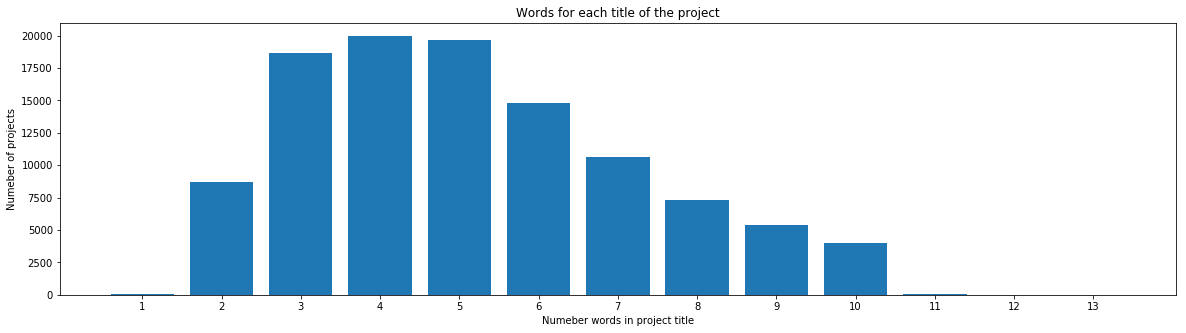

In [25]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [26]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

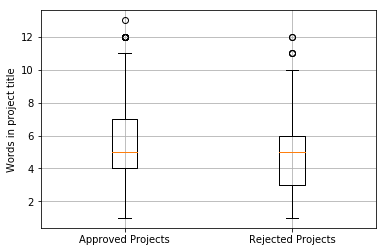

In [27]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

#### Observations

1.Most of the Projects which are approved have 4 to 7 words in the title.


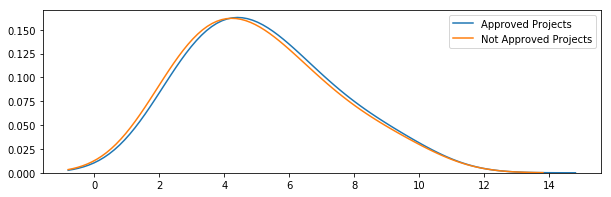

In [28]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

#### Obseravtiosn

Projects which are approved have slighty higher number of words in Titls as compared to projects which are not approved

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [29]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [30]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

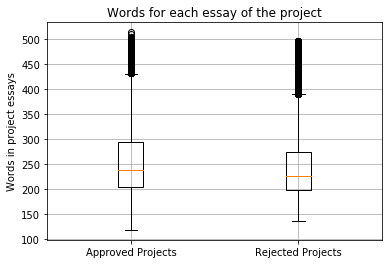

In [31]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

#### Observations

1. Most of the Projects approved have 200 to 300 words in Essay. 
2. Avg word count of Project Approved is slighty higher as compared to those projects that have not been approved.

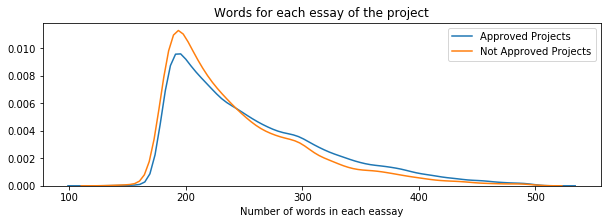

In [32]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

#### Observation

1. Pdf of approved projects is slighty more than Pdf of Not approved Projects after word count 230.
2. WE observe that Projects which have approved have a higher word count as compared to projects ehich are not approved

### 1.2.8 Univariate Analysis: Cost per project

In [33]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [34]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id  quantity   price
0  p000001         7  459.56
1  p000002        21  515.89

In [35]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [36]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

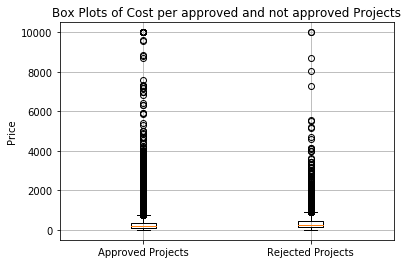

In [37]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

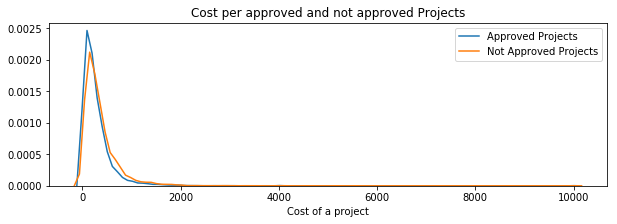

In [38]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [39]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

#### Observations

a 50% of the Projects that are approved are under $200.

b 75% of the Projects that are approved are under $370.

c Maximum Projects that are approved are under $1000.

### 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects


In [40]:
pric_data = project_data.groupby('teacher_id').agg({'teacher_number_of_previously_posted_projects':'sum'}).reset_index()
pric_data.head(2)

teacher_id  \
0  00000f7264c27ba6fea0c837ed6aa0aa   
1  00002d44003ed46b066607c5455a999a   

   teacher_number_of_previously_posted_projects  
0                                             2  
1                                             1

In [41]:
approve_project = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

reject_project = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

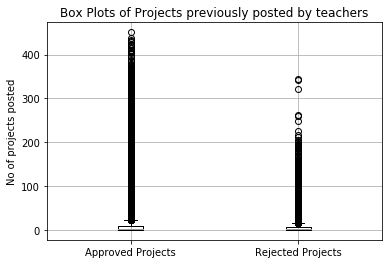

In [42]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html

plt.boxplot([approve_project, reject_project])

plt.title('Box Plots of Projects previously posted by teachers')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('No of projects posted')
plt.grid()

plt.show()

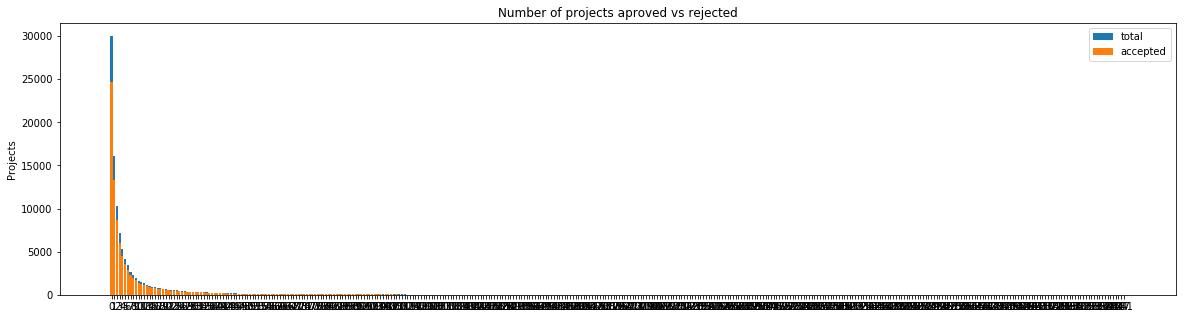

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [43]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved' , top=False)

#### Observations

Teachers who are posting Projects for the first time or who have priviously not posted any projects have a higher number of Projects approved as comparted to teachers who have posted many projects earlier. New talent is encouraged and appreciated.

### 1.2.10 Univariate Analysis: project_resource_summary

Check if the presence of the numerical digits in the project_resource_summary effects the acceptance of the project or not. If you observe that presence of the numerical digits is helpful in the classification, please include it for further process or you can ignore it.

In [44]:
import re
temp= project_data

#https://developers.google.com/edu/python/regular-expressions

sub_catogories = list(project_data['project_resource_summary'].values)
cat_list=[]
for sentance in sub_catogories:
    match= re.search(r'[0-9]',sentance) 
    if match:   
        cat_list.append(1)
    else: 
        cat_list.append(0)

        
temp['numerical_resource_summary']= cat_list     

In [45]:
temp.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   
1  The projector we need for our school is very c...  ...             NaN   
2  The students on the campus come to school know...  ...             NaN   
3  My students live in high poverty conditions wi...  ...             NaN   
4  For many students, math is a subject that does...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   
3  My students need to engage in Reading and Math...   
4  My students need hands on practice in mathemat...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   
2                                            1                    0   
3                                            4                    1   
4                                            1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay quantity   price  \
0  My students are English learners that are work...       23  154.60   
1  Our students arrive to our school eager to lea...        1  299.00   
2  \r\n\"True champions aren't always the ones th...       22  516.85   
3  I work at a unique school filled with both ESL...        4  232.90   
4  Our second grade classroom next year will be m...        4   67.98   

   numerical_resource_summary  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  

[5 rows x 21 columns]

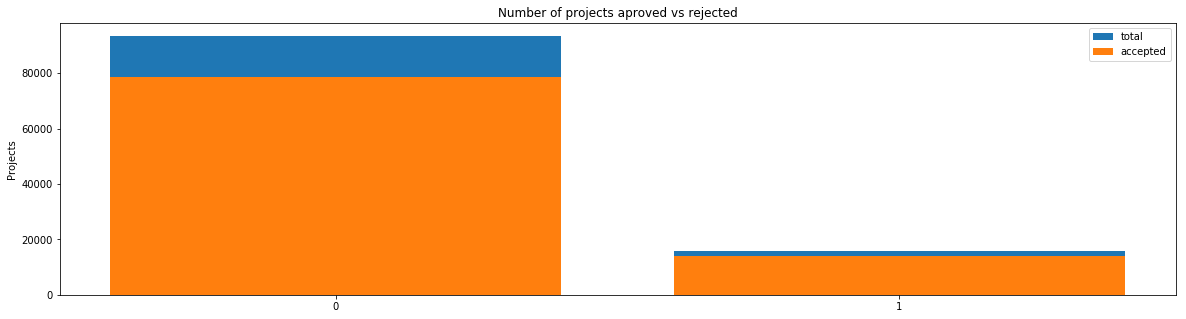

   numerical_resource_summary  project_is_approved  total       Avg
0                           0                78616  93492  0.840885
1                           1                14090  15756  0.894263
   numerical_resource_summary  project_is_approved  total       Avg
0                           0                78616  93492  0.840885
1                           1                14090  15756  0.894263


In [46]:
univariate_barplots(project_data,'numerical_resource_summary' , 'project_is_approved' , top=False)

#### Observations

1. If a project resource summary contains anumerical values then it is approved 90% of time. With numerica values the proposals become precise and Donors tend to donate more.

2. Most of the project resource summary does not contain nymerical values.

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [47]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   
1  The projector we need for our school is very c...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay quantity  price  \
0  My students are English learners that are work...       23  154.6   
1  Our students arrive to our school eager to lea...        1  299.0   

   numerical_resource_summary  
0                           0  
1                           0  

[2 rows x 21 columns]

In [48]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [49]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [51]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [52]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [53]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [54]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essay = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essay.append(sent.lower().strip())



100%|██████████| 109248/109248 [01:13<00:00, 1484.72it/s]


In [55]:
# after preprocesing
preprocessed_essay[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [56]:
len(preprocessed_essay)

109248

### 1.3.2 Project title Text

In [57]:
# printing some project title.
print(project_data['project_title'].values[54])
print("="*50)
print(project_data['project_title'].values[170])
print("="*50)
print(project_data['project_title'].values[1079])
print("="*50)
print(project_data['project_title'].values[26800])
print("="*50)
print(project_data['project_title'].values[99659])
print("="*50)

Swim For Life At YMCA!
Alternative Seating for Comfy Classrooms
Hands on Art : Eric Carle
Fidgeting to Success
Touch Screen Techies: QR Code Audio Library & Literacy Apps


In [58]:
from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_project_title .append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 33535.24it/s]


In [59]:
preprocessed_project_title[170]

'alternative seating comfy classrooms'

## 1. 4 Preparing data for models

In [60]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'quantity', 'price',
       'numerical_resource_summary'],
      dtype='object')

we are going to consider

   - school_state : categorical data
   - clean_categories : categorical data
   - clean_subcategories : categorical data
   - project_grade_category : categorical data
   - teacher_prefix : categorical data

   - project_title : text data
   - text : text data
   - project_resource_summary: text data

   - quantity : numerical
   - teacher_number_of_previously_posted_projects : numerical
   - price : numerical

### 1.4.1 Vectorizing Categorical data

##### A. Project Categories

In [61]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Literacy_Language', 'Care_Hunger', 'Health_Sports', 'Music_Arts', 'Math_Science', 'SpecialNeeds', 'History_Civics', 'Warmth', 'AppliedLearning']
Shape of matrix after one hot encodig  (109248, 9)


##### B. Project Sub-Categories

In [62]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Literature_Writing', 'Literacy', 'Mathematics', 'College_CareerPrep', 'AppliedSciences', 'Gym_Fitness', 'PerformingArts', 'SpecialNeeds', 'Health_Wellness', 'History_Geography', 'NutritionEducation', 'VisualArts', 'ForeignLanguages', 'Other', 'Health_LifeScience', 'CommunityService', 'TeamSports', 'Extracurricular', 'FinancialLiteracy', 'SocialSciences', 'Warmth', 'EarlyDevelopment', 'ESL', 'Economics', 'Civics_Government', 'Care_Hunger', 'CharacterEducation', 'Music', 'ParentInvolvement', 'EnvironmentalScience']
Shape of matrix after one hot encodig  (109248, 30)


##### C. School State

In [63]:
#One Hot Encode - school_state
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())

school_state_dict = dict(my_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1])) 


In [64]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())



school_state_one_hot = vectorizer.transform(project_data['school_state'].values)

print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['MI', 'NM', 'CT', 'OR', 'WV', 'AL', 'UT', 'NY', 'IN', 'ND', 'MD', 'NV', 'CO', 'NC', 'PA', 'ME', 'TX', 'WY', 'ID', 'NE', 'SC', 'MS', 'NH', 'MO', 'VT', 'WA', 'OK', 'SD', 'WI', 'AR', 'IA', 'MT', 'TN', 'IL', 'FL', 'AK', 'LA', 'DC', 'CA', 'VA', 'KY', 'GA', 'RI', 'NJ', 'KS', 'MN', 'AZ', 'HI', 'MA', 'OH', 'DE']
Shape of matrix after one hot encodig  (109248, 51)


##### D. Project Grade Category

In [65]:
#One Hot Encode - Project Grade Category
my_counter = Counter()
for word in project_data['project_grade_category'].values:
    my_counter.update(word.replace('Grades',' ').split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))    

In [66]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(project_data['project_grade_category'].values)



print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)

['3-5', '6-8', 'PreK-2', '9-12']
Shape of matrix after one hot encodig  (109248, 4)


##### E. Teacher Prefix

In [67]:
#One Hot Encode - Teacher Prefix
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    word = str(word)
    my_counter.update(word.replace('.',' ').replace('nan',' ').split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict= dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))  

In [68]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
#this category returns a ValueError: np.nan
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['Mrs', 'Dr', 'Teacher', 'Ms', 'Mr']
Shape of matrix after one hot encodig  (109248, 5)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words on preprocessed essays

In [69]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
preprocessed_essays_bow = vectorizer.fit_transform(preprocessed_essay)
print("Shape of matrix after one hot encodig ",preprocessed_essays_bow.shape)
print("the type of count vectorizer ",type(preprocessed_essays_bow))
print("the number of unique words ", preprocessed_essays_bow.get_shape()[1])

Shape of matrix after one hot encodig  (109248, 16623)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  16623


#### 1.4.2.2 Bag of Words on project_title

In [70]:
# We are considering only the words which appeared in at least 5 project title.
vectorizer = CountVectorizer(min_df=10)
preprocessed_project_title_bow = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",preprocessed_project_title_bow.shape)
print("the type of count vectorizer ",type(preprocessed_project_title_bow))
print("the number of unique words ", preprocessed_project_title_bow.get_shape()[1])

Shape of matrix after one hot encodig  (109248, 3329)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words  3329


####  1.4.2.3 TFIDF vectorizer preprocessed essays

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
essay_tfidf = vectorizer.fit_transform(preprocessed_essay)
print("Shape of matrix after one hot encodig ",essay_tfidf.shape)
print("the number of unique words ", essay_tfidf.get_shape()[1])


Shape of matrix after one hot encodig  (109248, 16623)
the number of unique words  16623


#### 1.4.2.4 TFIDF Vectorizer on project_title

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4)
project_title_tfidf = vectorizer.fit_transform(preprocessed_project_title)
print("Shape of matrix after one hot encodig ",project_title_tfidf.shape)
print("the number of unique words ", project_title_tfidf.get_shape()[1])

Shape of matrix after one hot encodig  (109248, 5848)
the number of unique words  5848


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [73]:
import os
os. getcwd()

'/home/deekshant_khitoliya/Untitled Folder'

In [74]:
#https://github.com/jupyter/help/issues/229
#unzipping file in ipython
#from shutil import unpack_archive
#unpack_archive('glove.42B.300d.zip', '/home/deekshant_khitoliya/Untitled Folder')

In [75]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [76]:
model = loadGloveModel('glove.42B.300d.txt')

325it [00:00, 3247.57it/s]

Loading Glove Model


1917900it [04:03, 7876.90it/s]

Done. 1917495  words loaded!


In [77]:
words = []

for i in preprocessed_essay :
    words.extend(i.split(' '))
    
for i in preprocessed_project_title:
    words.extend(i.split(' '))

In [78]:
print("all the words in the coupus", len(words))

all the words in the coupus 17014413


In [79]:
words = set(words)
print("the unique words in the corpus", len(words))

the unique words in the corpus 58968


In [80]:
inter_words = set(model.keys()).intersection(words)

print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

The number of words that are present in both glove vectors and our coupus 51503 ( 87.341 %)


In [81]:
words_corpus = {}

words_glove = set(model.keys())

for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]

print("word 2 vec length", len(words_corpus))

word 2 vec length 51503


In [82]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f)

In [83]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

#### Avg W2V on Project Essays

#### Avg W2V on Project Title

In [85]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:01<00:00, 56445.31it/s]

109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V on Project Essays

#### 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on project_title

In [85]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_project_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [86]:
# average Word2Vec
# compute average word2vec for each Project Title
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_project_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)
    
print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))

100%|██████████| 109248/109248 [00:04<00:00, 22620.39it/s]

109248
300


### 1.4.3 Vectorizing Numerical features

####  A. Price

In [87]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation :{}".format(np.sqrt(price_scalar.var_[0])))

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608
Standard deviation :367.49634838483496


In [88]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

#### Observations

The average Price of each Project is 299 dollars

#### B  . Number of Previously  Proposed Projects by the Teacher

In [89]:
previous_projects = StandardScaler()
previous_projects.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data

print("Mean : {}".format(previous_projects.mean_[0]))
print("Standard deviation :{}".format(np.sqrt(previous_projects.var_[0])))

previous_projects_standardized = price_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))





Mean : 11.153165275336848
Standard deviation :27.77702641477403


In [90]:
previous_projects_standardized

array([[-0.81121716],
       [-0.79216935],
       [-0.80849604],
       ...,
       [-0.80305381],
       [-0.81121716],
       [-0.81121716]])

#### Observations

The average number of Previously Proposed Projects by the Teacher is 11.

### 1.4.4 Merging all the above features¶

In [91]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print( preprocessed_essays_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [92]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, preprocessed_essays_bow, price_standardized))
X.shape

(109248, 16663)

## Assignment 2: Apply TSNE

1. In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.
2. EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects
3. Build the data matrix using these features
    1. school_state : categorical data (one hot encoding)
    2. clean_categories : categorical data (one hot encoding)
    3. clean_subcategories : categorical data (one hot encoding)
    4. teacher_prefix : categorical data (one hot encoding)
    5. project_grade_category : categorical data (one hot encoding)
    6. project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)
    7. price : numerical
    8. teacher_number_of_previously_posted_projects : numerical
4. Now, plot FOUR t-SNE plots with each of these feature sets.
     1. categorical, numerical features + project_title(BOW)
     2. categorical, numerical features + project_title(TFIDF)
     3. categorical, numerical features + project_title(AVG W2V)
     4. categorical, numerical features + project_title(TFIDF W2V)
     5. Concatenate all the features and Apply TNSE on the final data matrix


Note 1: The TSNE accepts only dense matrices
Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using

### We will be considering only 5000 data points of our original data set.

### 2.1 TSNE with `BOW` encoding of `project_title` feature 

In [93]:

print('data matrix for categorical variables')

print("\n")
print('shape of data matrix for school state is:{}'.format(school_state_one_hot.shape))
print("="*50)
print('shape of data matrix for project categories is:{}'.format(categories_one_hot.shape))
print("="*50)
print('shape of data matrix for project sub -categories is:{}'.format(sub_categories_one_hot.shape))
print("="*50)
print('shape of data matrix for project teacher prefix is:{}'.format(teacher_prefix_one_hot.shape))
print("="*50)
print('shape of data matrix for project grade  is:{}'.format(project_grade_category_one_hot.shape))
print("\n")
print("="*50)
print("="*50)
print("\n")
print('data matrix for numerical variables')
print("\n")
print('shape of data matrix for project price  is:{}'.format(price_standardized.shape))
print("="*50)
print('shape of data matrix for previously posted projects bu teachers  is:{}'.format(previous_projects_standardized.shape))






data matrix for categorical variables


shape of data matrix for school state is:(109248, 51)
shape of data matrix for project categories is:(109248, 9)
shape of data matrix for project sub -categories is:(109248, 30)
shape of data matrix for project teacher prefix is:(109248, 6)
shape of data matrix for project grade  is:(109248, 5)




data matrix for numerical variables


shape of data matrix for project price  is:(109248, 1)
shape of data matrix for previously posted projects bu teachers  is:(109248, 1)


In [94]:
print('data matrix for text variables')
print("\n")
print('shape of data matrix for Project title Bag of Words Model(bow)  is:{}'.format(preprocessed_project_title_bow.shape))
print("="*50)
print('shape of data matrix for Project title TF-IDF Model  is:{}'.format(project_title_tfidf.shape))
print("="*50)
print('shape of data matrix for Project title Avg W2V  is:({},{})'.format(len(avg_w2v_vectors_titles),len(avg_w2v_vectors_titles[1])))
print("="*50)
print('shape of data matrix for Project title TF-IDF Avg W2V  is:({},{})'.format(len(tfidf_w2v_vectors_title),len(tfidf_w2v_vectors_title[1])))

data matrix for text variables


shape of data matrix for Project title Bag of Words Model(bow)  is:(109248, 3329)
shape of data matrix for Project title TF-IDF Model  is:(109248, 5848)
shape of data matrix for Project title Avg W2V  is:(109248,300)
shape of data matrix for Project title TF-IDF Avg W2V  is:(109248,300)


In [95]:
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
from scipy.sparse import hstack

X = hstack((school_state_one_hot, categories_one_hot, teacher_prefix_one_hot, sub_categories_one_hot,project_grade_category_one_hot,price_standardized,previous_projects_standardized,preprocessed_project_title_bow))
X.shape

(109248, 3432)

In [96]:
#https://www.kaggle.com/c/quora-question-pairs/discussion/33491


X=X.tocsr()
TSNE_BOW=X[0:5000,:]

In [97]:
labels = project_data["project_is_approved"]
new_labels = labels[0: 5000]
len(new_labels)

5000

In [98]:
#https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
from sklearn.manifold import TSNE

# creating a new data frame which help us in ploting the result data

top_5000 = TSNE_BOW.toarray()

model = TSNE(n_components=2, random_state=0,perplexity=10)
tsne_data = model.fit_transform(top_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, new_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "project_approval"))

    # Ploting the result of tsne
tsne_df.shape



(5000, 3)

In [99]:
tsne_df.head(5)

Dim_1      Dim_2  project_approval
0  25.867443  36.197220               0.0
1 -81.515762   5.115762               1.0
2 -82.578918   5.461241               0.0
3  51.809132  -4.597486               1.0
4  13.163678 -64.408989               1.0

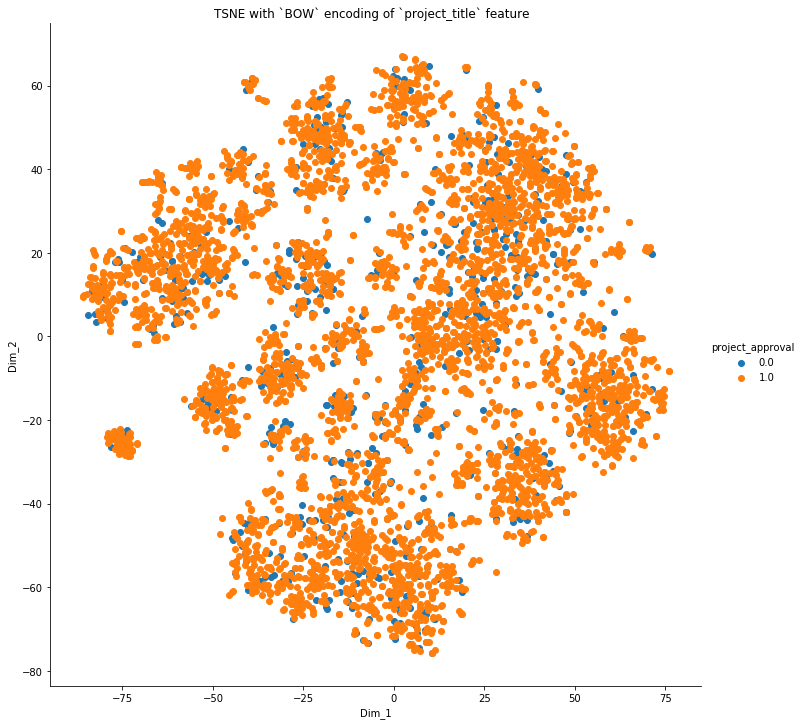

In [100]:
sns.FacetGrid(tsne_df, hue="project_approval", size=10).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with `BOW` encoding of `project_title` feature  ")
plt.show()

#### Observations 

There is a lot of overlapping, so we cant make any conclusions.

### 2.2 TSNE with `TFIDF` encoding of `project_title` feature 

In [101]:
X = hstack((school_state_one_hot, categories_one_hot, teacher_prefix_one_hot, sub_categories_one_hot,project_grade_category_one_hot,price_standardized,previous_projects_standardized,project_title_tfidf))
X.shape

(109248, 5951)

In [102]:
#https://www.kaggle.com/c/quora-question-pairs/discussion/33491
X=X.tocsr()
TSNE_TF_IDF =X[0:5000,:]

In [103]:
labels = project_data["project_is_approved"]
new_labels = labels[0: 5000]
len(new_labels)

5000

In [104]:
#https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
from sklearn.manifold import TSNE

# creating a new data frame which help us in ploting the result data

top_5000 = TSNE_TF_IDF.toarray()

model = TSNE(n_components=2, random_state=0,perplexity=10)
tsne_data = model.fit_transform(top_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, new_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "project_approval"))

    # Ploting the result of tsne
tsne_df.shape

(5000, 3)

In [105]:
tsne_df.head(5)

Dim_1       Dim_2  project_approval
0 -72.161201   43.476120               0.0
1  18.964579 -106.079643               1.0
2  22.066252  -74.817284               0.0
3  25.657347   89.226715               1.0
4  47.784008  -40.506348               1.0

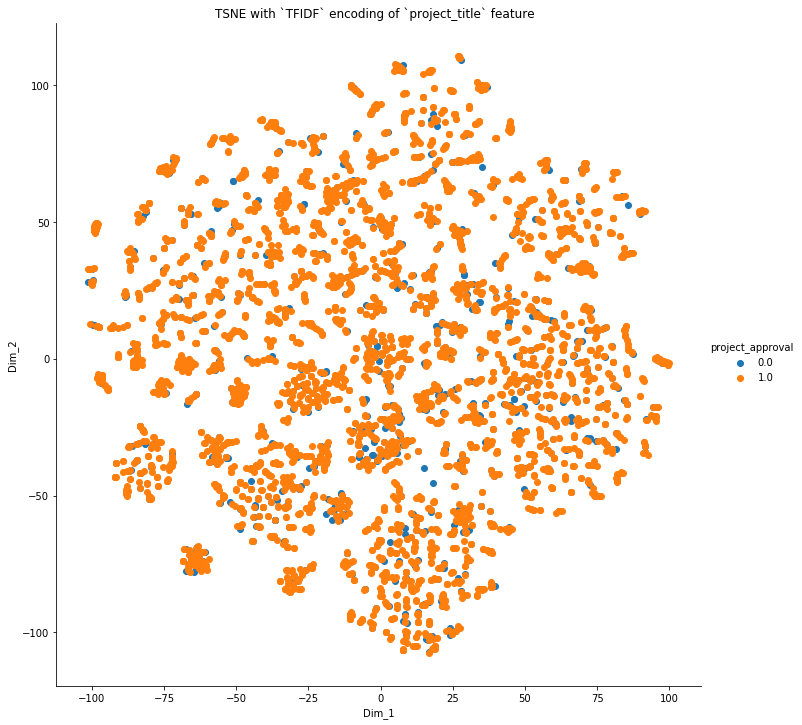

In [106]:
sns.FacetGrid(tsne_df, hue="project_approval", size=10).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with `TFIDF` encoding of `project_title` feature  ")
plt.show()

#### Observations

With TSNE plot we did ot observe any clusters of the projects that are approved and the Projects that are not approved

### 2.3 TSNE with `AVG W2V` encoding of `project_title` feature 

In [107]:
X = hstack((school_state_one_hot, categories_one_hot, teacher_prefix_one_hot, sub_categories_one_hot,project_grade_category_one_hot,price_standardized,previous_projects_standardized,avg_w2v_vectors_titles))
X.shape

(109248, 403)

In [108]:
#https://www.kaggle.com/c/quora-question-pairs/discussion/33491
X=X.tocsr()
TSNE_AVG_W2V =X[0:5000,:]

In [109]:
labels = project_data["project_is_approved"]
new_labels = labels[0: 5000]
len(new_labels)

5000

In [110]:
#https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
from sklearn.manifold import TSNE

# creating a new data frame which help us in ploting the result data

top_5000 = TSNE_AVG_W2V.toarray()

model = TSNE(n_components=2, random_state=0,perplexity=10)
tsne_data = model.fit_transform(top_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, new_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "project_approval"))

    # Ploting the result of tsne
tsne_df.shape

(5000, 3)

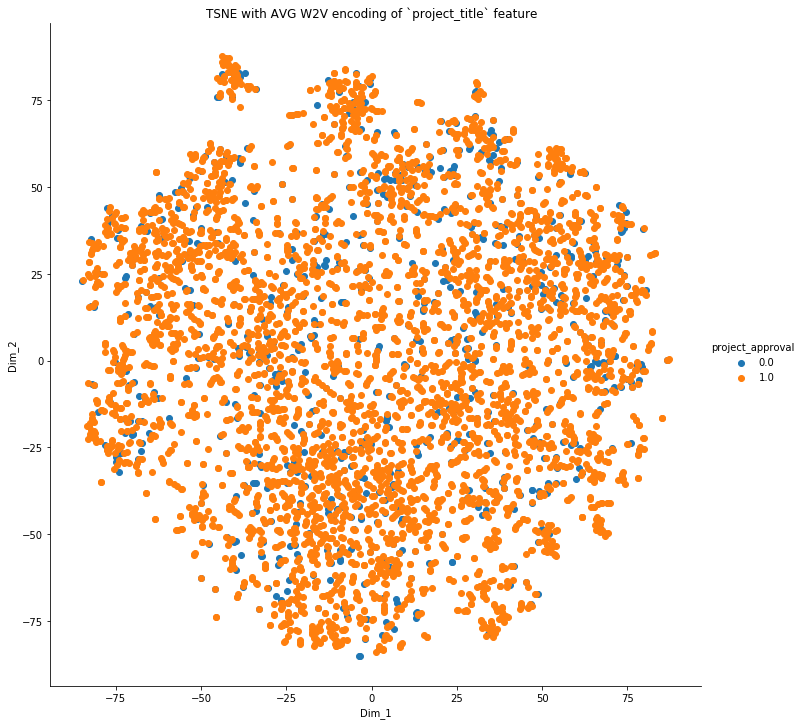

In [111]:
sns.FacetGrid(tsne_df, hue="project_approval", size=10).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with AVG W2V encoding of `project_title` feature  ")
plt.show()

#### Observations

It is quite difficult to draw any conclusion as the points are scattered everwhere. It is quite impossible to differentiate between the projects that are not approved and the projects that are approved

### 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature 

In [112]:
X = hstack((school_state_one_hot, categories_one_hot, teacher_prefix_one_hot, sub_categories_one_hot,project_grade_category_one_hot,price_standardized,previous_projects_standardized,tfidf_w2v_vectors_title))
X.shape

(109248, 403)

In [113]:
X=X.tocsr()
TSNE_TFIDF_AVG_W2V =X[0:5000,:]

In [114]:
labels = project_data["project_is_approved"]
new_labels = labels[0: 5000]
len(new_labels)

5000

In [115]:
#https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
from sklearn.manifold import TSNE

# creating a new data frame which help us in ploting the result data

top_5000 = TSNE_TFIDF_AVG_W2V.toarray()

model = TSNE(n_components=2, random_state=0,perplexity=10)
tsne_data = model.fit_transform(top_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, new_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "project_approval"))

    # Ploting the result of tsne
tsne_df.shape

(5000, 3)

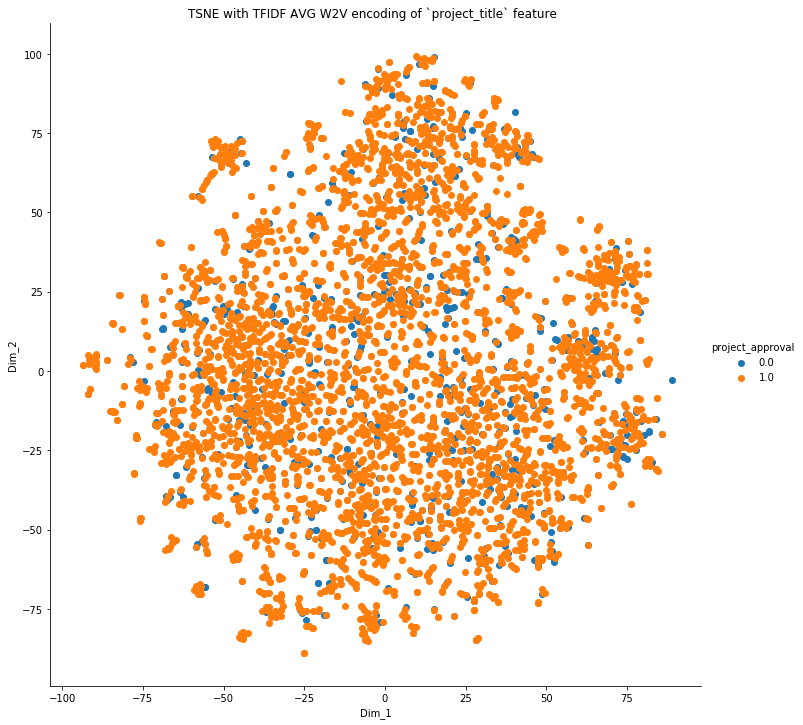

In [116]:
sns.FacetGrid(tsne_df, hue="project_approval", size=10).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with TFIDF AVG W2V encoding of `project_title` feature  ")
plt.show()

#### Observations

1. We do not observe any clustering of simiar data points, hence we are not able to provide any valid conclusions.
2. we might have to try some other dimensionality reduction technique.

### 2.5 TSNE with BOW, TFIDF, AVG W2V, TFIDF Weighted W2V encoding of project_title feature

In [117]:
X = hstack((school_state_one_hot, categories_one_hot, teacher_prefix_one_hot, sub_categories_one_hot,project_grade_category_one_hot,price_standardized,previous_projects_standardized,preprocessed_project_title_bow,project_title_tfidf,avg_w2v_vectors_titles,tfidf_w2v_vectors_title))
X.shape

(109248, 9880)

In [118]:
X=X.tocsr()
Final_matrix =X[0:5000,:]

In [119]:
#https://stackoverflow.com/questions/50198409/how-to-apply-t-sne-on-word2vec-model
from sklearn.manifold import TSNE

# creating a new data frame which help us in ploting the result data

top_5000 = Final_matrix.toarray()

model = TSNE(n_components=2, random_state=0,perplexity=10)
tsne_data = model.fit_transform(top_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, new_labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "project_approval"))

    # Ploting the result of tsne
tsne_df.shape

(5000, 3)

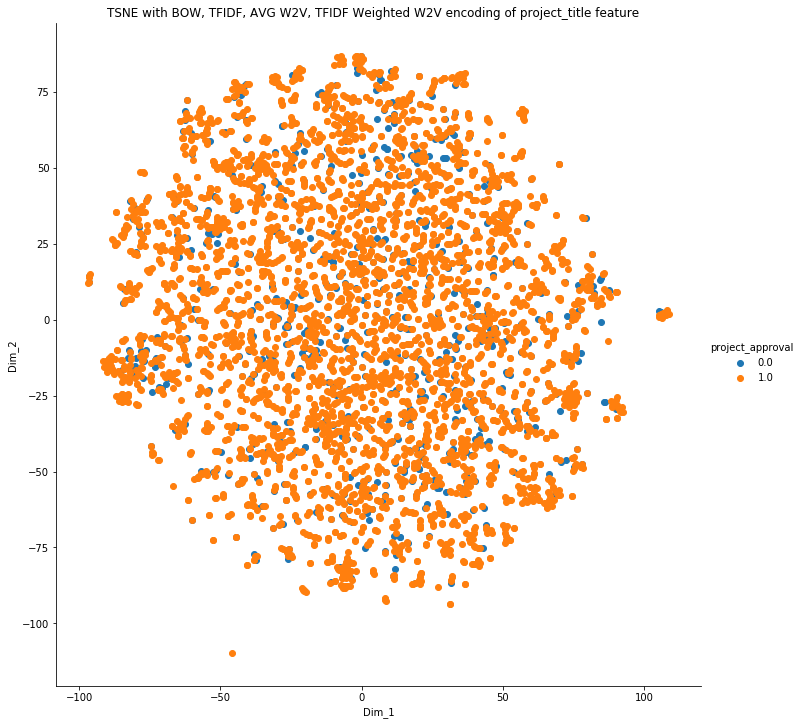

In [120]:
sns.FacetGrid(tsne_df, hue="project_approval", size=10).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with BOW, TFIDF, AVG W2V, TFIDF Weighted W2V encoding of project_title feature   ")
plt.show()

#### Observations

We are not able to make any valid conclusions as the data is not linearly separable. As with TSNE we were not able to oberverve any clusters.

## Conclusion

1. Deleware State has a 90% Project Approval rate. On the other hand states like vermont have less than average Project approval rate only 80%.

2. Also Experienced Teacher have more no of Project Approval than a new teacher.

3. Female teachers have posted more projects than male teachers.

4. As the grade of student increases the number of projects posted by teachers deacrease and also numbar of projects approved deacreases.Maximum Projects that are aposted  belong to students of grade prep2 to 5.
    
5. Maximum Projects that are aposted belong to Literacy and Language subject category. Also in this category the projects have a approval rate of 86%.Project which belong to categories Warmth,Care,Hunger have a approval rate of 93%. Maybe the Donors are more sympathetic towards hunger and poverty.

6. Literacy Language when combined with any other category increase the chance of Project Approval to above 85%.

7. Project which belong to sub-category Literacy have highest numbaer of projects approved. Projects which belong to sub-category college and career prep have lowest number of projects approved.

8. 50% of Projects Approved have 4 to 7 words in their project Title. Projects which are not approved have slighty less Number of words in their Project Title.

9. Projects which are approved have slightly more words in their essays as compared to Projects which are not approved.

10. 75% of the projects approved have proposed cost of less than 370 Dollars .The Average price of each Project is 299 Dollars.

11. Teachers who are posting their projects for the first time or have earlier posted very few  projects have higher chance of getting their project approved as compared to teachers who have posted many projects earlier. The average numbaer of previously posted Projects by teachers are 11.

12. From the Project Resource summary it looks like the projects which involve some numerical description about the projects have a much higher chance of approval as compared to projects which do not involve any numerical description.As numerical values make the project proposals consise. Most of the projects posted doen not involve any numerical description.

13. When we applied Dimensionality reduction technique Tsne with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec on Project Title, we were  not able to draw any conclusions as there was a lot of overlapping of data points. We were expecting to form some clusters of Projects Approved and Projects Not Approved. This was not Possible and we came to know that our data is not linearlly seperable and it need further investigation to yiels clusters.